# Zero Inflated AB Testing

Adapted from https://www.pymc.io/projects/examples/en/stable/case_studies/bayesian_ab_testing_introduction.html#value-conversions

The revenue generated by an individual visitor is `revenue = probability of paying at all * mean amount spent when paying`:

$\text{Revenue}_i = \text{Bernoulli}(\theta)_i * \text{Exponential}(\lambda)_i I(\text{Bernoulli}(\theta)_i = 1)$

We assume that the probability of paying at all is independent of the mean amount spent when paying. This is a typical assumption in practice, unless we have reason to believe that the two parameters have dependencies. With this, we can create separate models for the total number of visitors paying, and the total amount spent amongst the purchasing visitors (assuming independence between the behaviour of each visitor):

$c \sim \sum_{i=1}^{N} \text{Bernoulli}(\theta) = \text{Binomial}(N, \theta)$

$r \sim \sum_{i=1}^{K} \text{Exponential}(\lambda) = \text{Gamma}(K, \lambda)$

where $N$ is the total number of visitors, \(K\) is the total number of visitors with at least one purchase.

We can re-use our Beta-Binomial model from before to model the Bernoulli conversions. For the mean purchase amount, we use a Gamma prior (which is also a conjugate prior to the Gamma likelihood). So in a two-variant test, the setup is:

$\theta_A \sim \theta_B \sim \text{Beta}(\alpha_1, \beta_1)$

$\lambda_A \sim \lambda_B \sim \text{Gamma}(\alpha_2, \beta_2)$

$c_A \sim \text{Binomial}(N_A, \theta_A), c_B \sim \text{Binomial}(N_B, \theta_B)$

$r_A \sim \text{Gamma}(c_A, \lambda_A), r_B \sim \text{Gamma}(c_B, \lambda_B)$

$\mu_A = \theta_A * \frac{1}{\lambda_A}, \mu_B = \theta_B * \frac{1}{\lambda_B}$

$\text{reluplift}_B = \frac{\mu_B}{\mu_A} - 1$

$\mu$ here represents the average revenue per visitor, including those who don’t make a purchase. This is the best way to capture the overall revenue effect - some variants may increase the average sales value, but reduce the proportion of visitors that pay at all 


In [1]:
from dataclasses import dataclass
from typing import Dict, List, Union
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.stats import bernoulli, expon

plotting_defaults = dict(
    bins=50,
    kind="hist",
    textsize=10,
)

## PARAMETERS

Tunables for personalisation.
If A/B/C split for example, increase the length of these parameters.

In [123]:
VARIANTS = ['A', 'B']
NCUSTOMERS = [2000, 2000] # number in A and B
TRUE_CONVERSION_RATES = [0.2, 0.2] # conversion rates used in simulated data
TRUE_MEAN_PURCHASE = [200, 210] # true mean purchase amounts used in simlated data
COMPARISON_METRIC = 'compare_to_control' # comparison - "compare_to_control" or "best_of_rest" explained below

## Setup 

In [124]:
# mean purchase amount prior (lambda). Mean of gamma = alpha / beta
@dataclass
class GammaPrior:
    alpha: float
    beta: float
# For the Beta prior, we can set it to be centered around 0.5, 
# with the magnitude of alpha and beta determining how “thin” the distribution is.
@dataclass
class BetaPrior:
    alpha: float
    beta: float
# Revenue data class
@dataclass
class RevenueData:
    visitors: int
    purchased: int
    total_revenue: float

## Comparison Methods

### 1. Compare to Control

**Overview**: This method compares each variant directly to a control group (often the baseline or original version) to assess the impact of changes made in that variant.

**How it Works**:
- **Control Group**: In an A/B test, one group serves as the control (often the existing version), while others are variants with changes.
- **Metrics**: The conversion rates and revenue per visitor for each variant are compared against those of the control group.
- **Uplift Calculation**: For each variant $i$:
  - **Conversion Rate Uplift**:
    $\frac{\text{theta}_i}{\text{theta}_{\text{control}}} - 1$
  - **Mean Purchase Uplift**:
    $\frac{(1 / \text{lam}_i)}{(1 / \text{lam}_{\text{control}})} - 1$
  - **Revenue per Visitor Uplift**: 
    $\frac{\text{revenue\_per\_visitor}_i}{\text{revenue\_per\_visitor}_{\text{control}}} - 1$

**Advantages**:
- **Direct Comparison**: This method provides clear insights into how each variant performs relative to the original version.
- **Identifying Effective Changes**: It helps determine if the changes made in a variant positively or negatively impact the overall revenue generation compared to the control.

**Limitations**:
- **Control Group Dependence**: The effectiveness of the comparison relies heavily on the control group being a strong representative of typical behavior.

---

### 2. Best of Rest

**Overview**: This method compares each variant to the best-performing variant (excluding the current one) to evaluate how well it performs relative to its peers.

**How it Works**:
- **Identifying the Best**: For each variant $i$:
  - **Other Variants**: It considers all other variants (excluding $i$) to find the maximum conversion rate, mean purchase rate, and revenue per visitor among them.
- **Uplift Calculation**: The uplift metrics are calculated as follows:
  - **Conversion Rate Uplift**:
    $\frac{\text{theta}_i}{\text{max(theta of others)}} - 1$
  - **Mean Purchase Uplift**:
    $\frac{(1 / \text{lam}_i)}{(1 / \text{max(lam of others)})} - 1$
  - **Revenue per Visitor Uplift**:
    $\frac{\text{revenue\_per\_visitor}_i}{\text{max(revenue\_per\_visitor of others)}} - 1$

**Advantages**:
- **Relative Performance**: This approach focuses on identifying how well a variant performs against its best competitor, which can be useful for iterative testing and optimisation.
- **Encourages Innovation**: It encourages continuous improvement as each variant is compared to the highest-performing alternative rather than just the control.

**Limitations**:
- **Potential for Misleading Comparisons**: If the best-performing variant is an outlier, it may not provide a reliable basis for comparison.
- **Complexity**: This method can be more complex to interpret, as the “best of rest” might change with every new test iteration.

---

## Summary

Both methods serve distinct purposes:
- **"Compare to Control"** is straightforward and gives direct insights into how variants fare against a baseline.
- **"Best of Rest"** promotes a competitive atmosphere among variants, emphasizing relative performance and continuous improvement. 

When choosing between these methods, the context of the test and the goals of the analysis will play crucial roles in determining which approach is more suitable.


In [125]:
import pymc as pm
from typing import List

class RevenueModel:
    """
    A class to model revenue generation from visitors using a Bayesian framework.

    Attributes:
        conversion_rate_prior (BetaPrior): Prior distribution for the conversion rate.
        mean_purchase_prior (GammaPrior): Prior distribution for the mean purchase amount.
    """

    def __init__(self, conversion_rate_prior: BetaPrior, mean_purchase_prior: GammaPrior) -> None:
        """
        Initializes the RevenueModel with specified prior distributions.

        Parameters:
            conversion_rate_prior (BetaPrior): The prior for the conversion rate modeled using a Beta distribution.
            mean_purchase_prior (GammaPrior): The prior for the mean purchase amount modeled using a Gamma distribution.
        """
        self.conversion_rate_prior = conversion_rate_prior
        self.mean_purchase_prior = mean_purchase_prior

    def create_model(self, data: List[RevenueData], comparison_method: str) -> pm.Model:
        """
        Creates a Bayesian model for revenue generation based on visitor data.

        This method constructs a probabilistic model using PyMC3 to estimate the conversion rates
        and mean purchase amounts for different variants based on the observed data. It also calculates
        uplift metrics for each variant based on the specified comparison method.

        Parameters:
            data (List[RevenueData]): A list of RevenueData objects containing visitor counts,
                                       purchase counts, and total revenue for each variant.
            comparison_method (str): The method used for comparing variants. Options are:
                                     - "compare_to_control": Compare each variant to the control group.
                                     - "best_of_rest": Compare each variant to the best performing variant.

        Returns:
            pm.Model: A PyMC3 model object representing the revenue generation model.
        """
        num_variants = len(data)
        visitors = [d.visitors for d in data]
        purchased = [d.purchased for d in data]
        total_revenue = [d.total_revenue for d in data]

        with pm.Model() as model:
            theta = pm.Beta(
                "theta",
                alpha=self.conversion_rate_prior.alpha,
                beta=self.conversion_rate_prior.beta,
                shape=num_variants,
            )
            lam = pm.Gamma(
                "lam",
                alpha=self.mean_purchase_prior.alpha,
                beta=self.mean_purchase_prior.beta,
                shape=num_variants,
            )
            converted = pm.Binomial(
                "converted", n=visitors, p=theta, observed=purchased, shape=num_variants
            )
            revenue = pm.Gamma(
                "revenue", alpha=purchased, beta=lam, observed=total_revenue, shape=num_variants
            )
            revenue_per_visitor = pm.Deterministic("revenue_per_visitor", theta * (1 / lam))
            theta_reluplift = []
            reciprocal_lam_reluplift = []
            reluplift = []
            for i in range(num_variants):
                if comparison_method == "compare_to_control":
                    # compare to A (control)
                    comparison_theta = theta[0]
                    comparison_lam = 1 / lam[0]
                    comparison_rpv = revenue_per_visitor[0]
                elif comparison_method == "best_of_rest":
                    others_theta = [theta[j] for j in range(num_variants) if j != i]
                    others_lam = [1 / lam[j] for j in range(num_variants) if j != i]
                    others_rpv = [revenue_per_visitor[j] for j in range(num_variants) if j != i]
                    if len(others_rpv) > 1:
                        comparison_theta = pm.math.maximum(*others_theta)
                        comparison_lam = pm.math.maximum(*others_lam)
                        comparison_rpv = pm.math.maximum(*others_rpv)
                    else:
                        comparison_theta = others_theta[0]
                        comparison_lam = others_lam[0]
                        comparison_rpv = others_rpv[0]
                else:
                    raise ValueError(f"comparison method {comparison_method} not recognised.")
                theta_reluplift.append(
                    pm.Deterministic(f"theta_reluplift_{i}", theta[i] / comparison_theta - 1)
                )
                reciprocal_lam_reluplift.append(
                    pm.Deterministic(
                        f"reciprocal_lam_reluplift_{i}", (1 / lam[i]) / comparison_lam - 1
                    )
                )
                reluplift.append(
                    pm.Deterministic(f"reluplift_{i}", revenue_per_visitor[i] / comparison_rpv - 1)
                )
        return model

## Sample Prior Predictive

We generate data based on the prior distribution of the model parameters before observing any actual data. \
This approach helps us understand the implications of our prior beliefs about the parameters and can provide \
insights into the model's behavior and possible outcomes.

In [126]:
c_prior = BetaPrior(alpha=5000, beta=5000)
mp_prior = GammaPrior(alpha=9000, beta=900)

data = [
    RevenueData(visitors=1, purchased=1, total_revenue=1),
    RevenueData(visitors=1, purchased=1, total_revenue=1),
]

In [127]:
with RevenueModel(c_prior, mp_prior).create_model(data, COMPARISON_METRIC):
    revenue_prior_predictive = pm.sample_prior_predictive(samples=10000, return_inferencedata=False)

Sampling: [converted, lam, revenue, theta]


The width of the prior predictive uplift distribution will depend on the strength of our priors

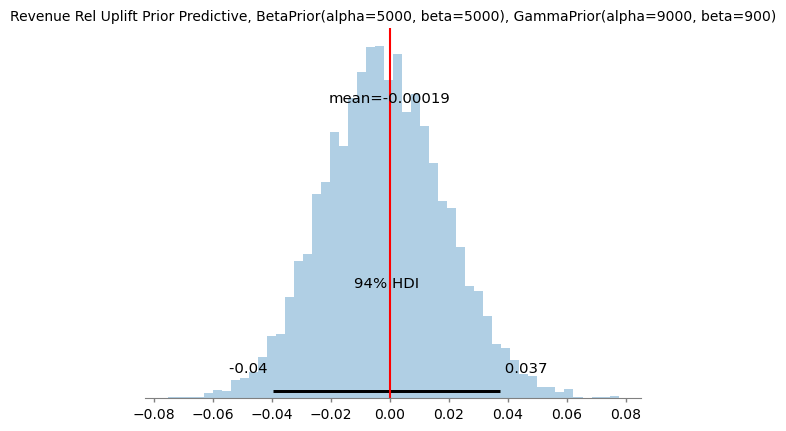

In [128]:
fig, ax = plt.subplots()
az.plot_posterior(revenue_prior_predictive["reluplift_1"], ax=ax, **plotting_defaults)
ax.set_title(f"Revenue Rel Uplift Prior Predictive, {c_prior}, {mp_prior}", fontsize=10)
ax.axvline(x=0, color="red");

## Generate Synthetic Data

Next we generate synthetic data for the model. We’ll generate the following scenarios:

* Same propensity to purchase and same mean purchase value.

* Lower propensity to purchase and higher mean purchase value, but overall same revenue per visitor.

* Higher propensity to purchase and higher mean purchase value, and overall higher revenue per visitor.

In [129]:
def generate_revenue_data(
    variants: List[str],
    true_conversion_rates: List[float],
    true_mean_purchase: List[float],
    samples_per_variant: List[int],
) -> pd.DataFrame:
    """
    Generate simulated revenue data for different variants based on specified 
    conversion rates and mean purchase amounts.

    This function simulates the conversion behavior of visitors for each variant
    and calculates the total revenue based on the conversion and purchase distributions.

    Parameters:
        variants (List[str]): A list of variant names (strings) for which to generate data.
        true_conversion_rates (List[float]): A list of true conversion rates for each variant.
                                              Should be the same length as `variants`.
        true_mean_purchase (List[float]): A list of true mean purchase amounts for each variant.
                                           Should be the same length as `variants`.
        samples_per_variant (int): The number of samples to generate for each variant. Can be a list if different

    Returns:
        pd.DataFrame: A DataFrame containing aggregated data for each variant, including:
                       - visitors: The number of simulated visitors for each variant.
                       - purchased: The number of conversions (purchases) for each variant.
                       - total_revenue: The total revenue generated for each variant.
    """ 
    # added to allow for different number of samples in each variant
    if isinstance(samples_per_variant, (int, float)):
        samples_per_variant = [samples_per_variant]

    variant_results = []
    
    for variant, p, mp, samps in zip(variants, true_conversion_rates, true_mean_purchase, samples_per_variant):
        # Simulate conversion (1 for conversion, 0 for no conversion)
        converted = bernoulli.rvs(p, size=samps)
        # Simulate mean purchase values based on conversions
        mean_purchase = expon.rvs(scale=mp, size=samps)
        # Calculate revenue (converted * mean_purchase)
        revenue = converted * mean_purchase
        
        # Aggregate results for this variant
        variant_data = {
            "variant": variant,
            "visitors": samps,
            "purchased": converted.sum(),  # Total conversions
            "total_revenue": revenue.sum(),  # Total revenue
        }
        
        # Append the result for this variant
        variant_results.append(variant_data)
    
    # Convert list of dicts into a DataFrame
    agg_df = pd.DataFrame(variant_results).set_index("variant").T

    return agg_df

In [130]:
def run_scenario_value(
    variants: List[str],
    true_conversion_rates: List[float],
    true_mean_purchase: List[float],
    samples_per_variant: List[int],
    conversion_rate_prior: BetaPrior,
    mean_purchase_prior: GammaPrior,
    comparison_method: str,
) -> az.InferenceData:
    """
    Runs a Bayesian scenario analysis for different variants to estimate 
    revenue uplift based on simulated conversion data and prior distributions.

    This function generates simulated revenue data for specified variants, 
    builds a Bayesian model using the provided prior distributions, and 
    samples from the posterior to estimate the uplift in revenue per visitor 
    (RPV) for each variant compared to a specified comparison method.

    Parameters:
        variants (List[str]): A list of variant names for which to run the analysis.
        true_conversion_rates (List[float]): A list of true conversion rates for each variant.
        true_mean_purchase (List[float]): A list of true mean purchase amounts for each variant.
        samples_per_variant (int): The number of samples to generate for each variant.
        conversion_rate_prior (BetaPrior): The prior distribution for the conversion rate.
        mean_purchase_prior (GammaPrior): The prior distribution for the mean purchase amount.
        comparison_method (str): The method used for comparing variants. Options include:
                                 - "compare_to_control": Compare each variant to the control group.
                                 - "best_of_rest": Compare each variant to the best performing variant.

    Returns:
        az.InferenceData: An InferenceData object containing the posterior samples 
                          from the Bayesian model, which can be used for further 
                          analysis and visualization.
    """
    generated = generate_revenue_data(
        variants, true_conversion_rates, true_mean_purchase, samples_per_variant
    )
    print(generated)
    data = [RevenueData(**generated[v].to_dict()) for v in variants]
    
    with RevenueModel(conversion_rate_prior, mean_purchase_prior).create_model(data, comparison_method):
        trace = pm.sample(draws=5000, chains=2, cores=1)

    n_plots = len(variants)
    fig, axs = plt.subplots(nrows=n_plots, ncols=1, figsize=(3 * n_plots, 7), sharex=True)
    for i, variant in enumerate(variants):
        if i == 0 and comparison_method == "compare_to_control":
            axs[i].set_yticks([])
        else:
            az.plot_posterior(trace.posterior[f"reluplift_{i}"], ax=axs[i], **plotting_defaults)
        true_rpv = true_conversion_rates[i] * true_mean_purchase[i]
        axs[i].set_title(f"Rel Uplift {variant}, True RPV = {true_rpv:.2f}", fontsize=10)
        axs[i].axvline(x=0, color="red")
    fig.suptitle(f"Method {comparison_method}, {conversion_rate_prior}, {mean_purchase_prior}")

    return trace

## Scenario 1 - same underlying purchase rate and mean purchase value

variant                   A             B
visitors        2000.000000   2000.000000
purchased        395.000000    408.000000
total_revenue  82615.008124  89750.813379


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, lam]


Output()

Output()

Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


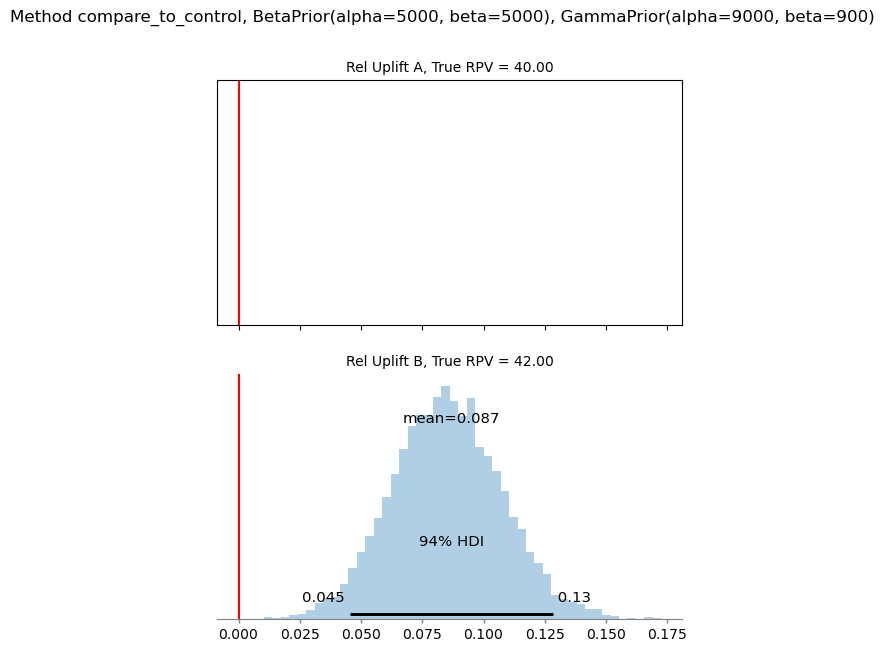

In [131]:
scen1  = run_scenario_value(
    variants=VARIANTS,
    true_conversion_rates=TRUE_CONVERSION_RATES,
    true_mean_purchase=TRUE_MEAN_PURCHASE,
    samples_per_variant=NCUSTOMERS,
    conversion_rate_prior=BetaPrior(alpha=5000, beta=5000),
    mean_purchase_prior=GammaPrior(alpha=9000, beta=900),
    comparison_method=COMPARISON_METRIC,
)

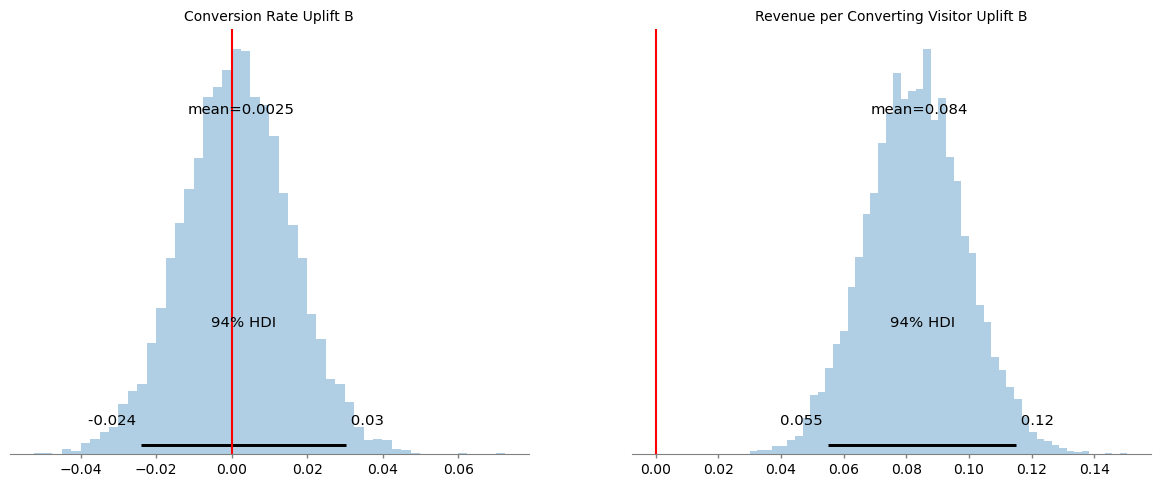

In [132]:
axs = az.plot_posterior(
    scen1,
    var_names=["theta_reluplift_1", "reciprocal_lam_reluplift_1"],
    **plotting_defaults,
)
axs[0].set_title(f"Conversion Rate Uplift B", fontsize=10)
axs[0].axvline(x=0, color="red")
axs[1].set_title(
    f"Revenue per Converting Visitor Uplift B", fontsize=10
)
axs[1].axvline(x=0, color="red")